In [9]:
%pip install pandas numpy matplotlib seaborn scikit-learn xgboost shap


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from pathlib import Path
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier  
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

INPUT_FILE = "../data/Master_Dataset_LinkedIn.csv"

Total rows: 5124

Class Distribution:
Is High Performing
0    0.5
1    0.5
Name: proportion, dtype: float64
Class ratio (0:1): 1.00

Training XGBoost with Enhanced Regularization...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best Hyperparameters:
  subsample: 0.5
  scale_pos_weight: 1
  reg_lambda: 20
  reg_alpha: 1.0
  n_estimators: 700
  min_child_weight: 10
  max_depth: 4
  learning_rate: 0.03
  gamma: 1.0
  colsample_bytree: 0.7
  colsample_bylevel: 0.5

Cross-Validation Performance:
  Training Accuracy:   0.7230
  Validation Accuracy: 0.6577
  Overfitting Gap:     0.0653
  ⚠ Moderate overfitting - consider more regularization

Test Set Performance:
  Accuracy:  0.6693
  ROC-AUC:   0.7359
  F1-Score:  0.6744
  Val-Test Gap: -0.0115
  ✓ Good generalization to test set!

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.65      0.66       513
           1       0.66      0.69      0.67       512

    accu

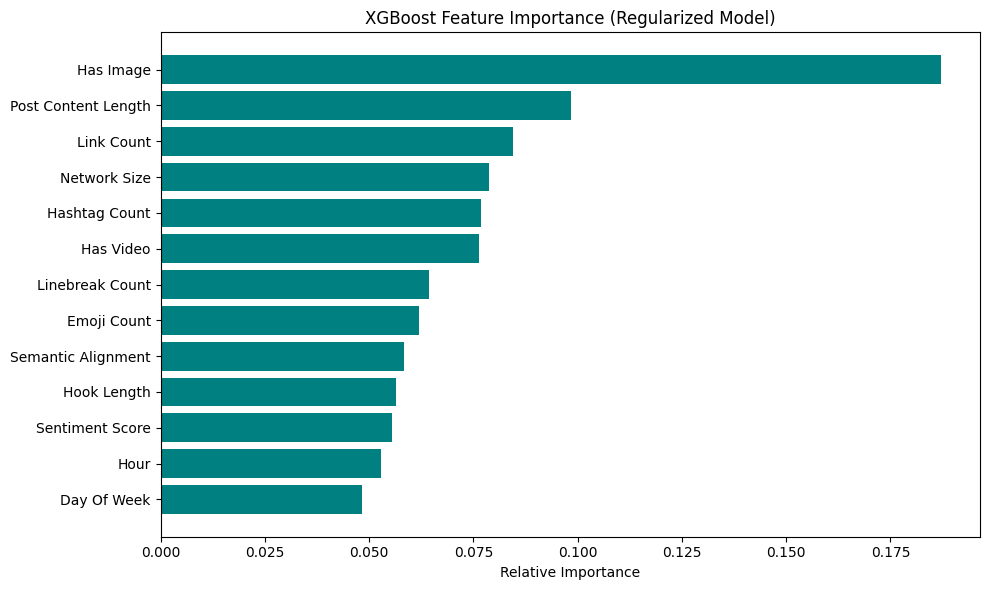

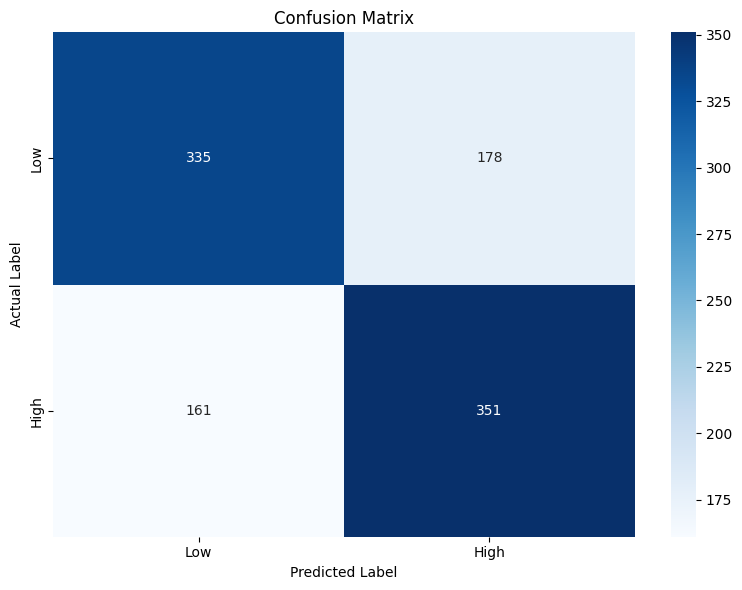


Generating Learning Curve...


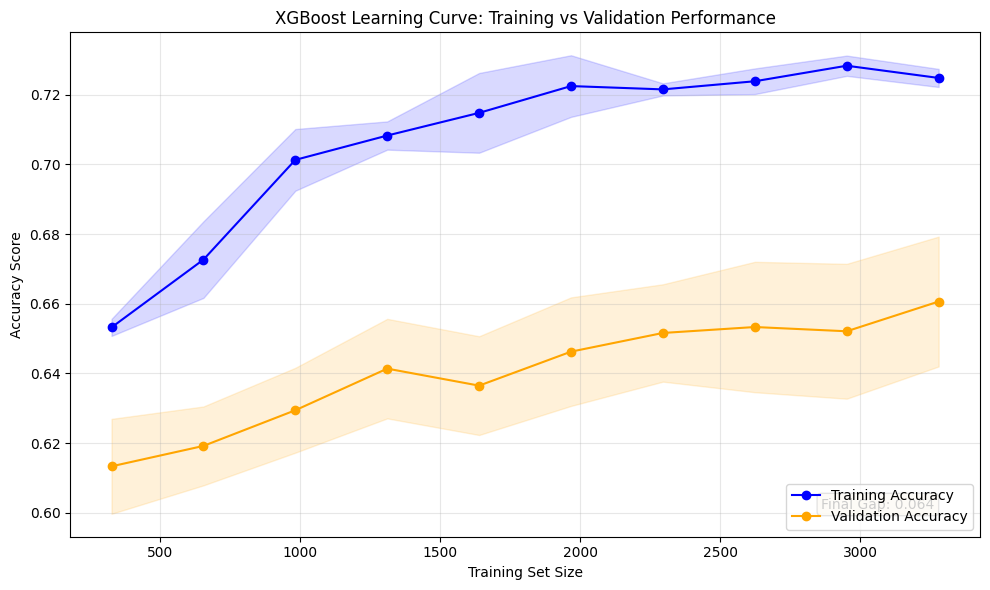

In [11]:
# XGBoost Classification Model with Enhanced Regularization & Diagnostics

# Load the dataset
df_ml = pd.read_csv(INPUT_FILE)

# Define Features (X) and Binary Target (y)
features = [
    'Network Size', 
    'Post Content Length',
    'Hook Length',
    'Semantic Alignment', 
    'Sentiment Score',
    'Emoji Count',
    'Hashtag Count',
    'Linebreak Count',
    'Link Count',
    'Hour', 
    'Day Of Week',
    'Has Image', 
    'Has Video'
]

X = df_ml[features]
y = df_ml['Is High Performing']

print(f"Total rows: {len(df_ml)}")

# Check class balance
print("\nClass Distribution:")
print(y.value_counts(normalize=True))
class_ratio = y.value_counts()[0] / y.value_counts()[1]
print(f"Class ratio (0:1): {class_ratio:.2f}")

# Train/Test/Split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# MODELING: XGBOOST WITH EVEN STRONGER REGULARIZATION
print("\nTraining XGBoost with Enhanced Regularization...")

# Aggressive regularization to close the overfitting gap
param_grid = {
    # Even simpler trees
    "max_depth": [2, 3, 4],  # Focus on shallower trees
    "min_child_weight": [10, 15, 20, 25],  # Higher minimum samples
    
    # Slower learning
    "learning_rate": [0.01, 0.02, 0.03],
    "n_estimators": [200, 300, 500, 700],
    
    # Stronger regularization
    "reg_alpha": [1.0, 2.0, 5.0, 10.0],  # Stronger L1
    "reg_lambda": [5, 10, 15, 20],  # Stronger L2
    
    # More aggressive sampling
    "subsample": [0.5, 0.6, 0.7],
    "colsample_bytree": [0.5, 0.6, 0.7],
    "colsample_bylevel": [0.5, 0.6, 0.7],
    
    # Higher split cost
    "gamma": [1.0, 2.0, 3.0, 5.0],
    
    # Handle class imbalance
    "scale_pos_weight": [1, class_ratio, class_ratio * 1.5],
}


# Use StratifiedKFold
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        random_state=42,
        n_jobs=-1
    ),
    param_distributions=param_grid,
    n_iter=100,  # More iterations for better search
    cv=cv_strategy,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)


search.fit(X_train, y_train)
best_model = search.best_estimator_

# Detailed performance analysis
cv_results = pd.DataFrame(search.cv_results_)
best_idx = search.best_index_
train_score = cv_results.loc[best_idx, 'mean_train_score']
val_score = cv_results.loc[best_idx, 'mean_test_score']
overfitting_gap = train_score - val_score

print(f"\n{'='*60}")
print(f"Best Hyperparameters:")
print(f"{'='*60}")
for param, value in search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nCross-Validation Performance:")
print(f"  Training Accuracy:   {train_score:.4f}")
print(f"  Validation Accuracy: {val_score:.4f}")
print(f"  Overfitting Gap:     {overfitting_gap:.4f}")
if overfitting_gap < 0.05:
    print(f"  ✓ Overfitting well controlled!")
elif overfitting_gap < 0.10:
    print(f"  ⚠ Moderate overfitting - consider more regularization")
else:
    print(f"  ✗ Significant overfitting detected")
print(f"{'='*60}")

# EVALUATION
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, auc

test_acc = accuracy_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred_proba)
test_f1 = f1_score(y_test, y_pred)

print(f"\nTest Set Performance:")
print(f"  Accuracy:  {test_acc:.4f}")
print(f"  ROC-AUC:   {test_auc:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")

# Check if test performance matches validation
val_test_gap = val_score - test_acc
print(f"  Val-Test Gap: {val_test_gap:.4f}")
if abs(val_test_gap) < 0.02:
    print(f"  ✓ Good generalization to test set!")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# VISUALIZATIONS

# 1. Feature Importance
importances = best_model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10, 6))
plt.title('XGBoost Feature Importance (Regularized Model)')
plt.barh(range(len(indices)), importances[indices], color='teal', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# 3. Learning Curve
from sklearn.model_selection import learning_curve

print("\nGenerating Learning Curve...")
train_sizes, train_scores, val_scores = learning_curve(
    best_model,
    X_train, 
    y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy', color='blue', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, val_mean, label='Validation Accuracy', color='orange', marker='o')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15, color='orange')

gap = train_mean[-1] - val_mean[-1]
plt.text(0.95, 0.05, f'Final Gap: {gap:.3f}', 
         transform=plt.gca().transAxes, 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
         verticalalignment='bottom', horizontalalignment='right')

plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('XGBoost Learning Curve: Training vs Validation Performance')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Generating SHAP analysis...
SHAP values shape: (1025, 13)
Expected shape: (1025, 13)

Plot 1: Global Feature Importance


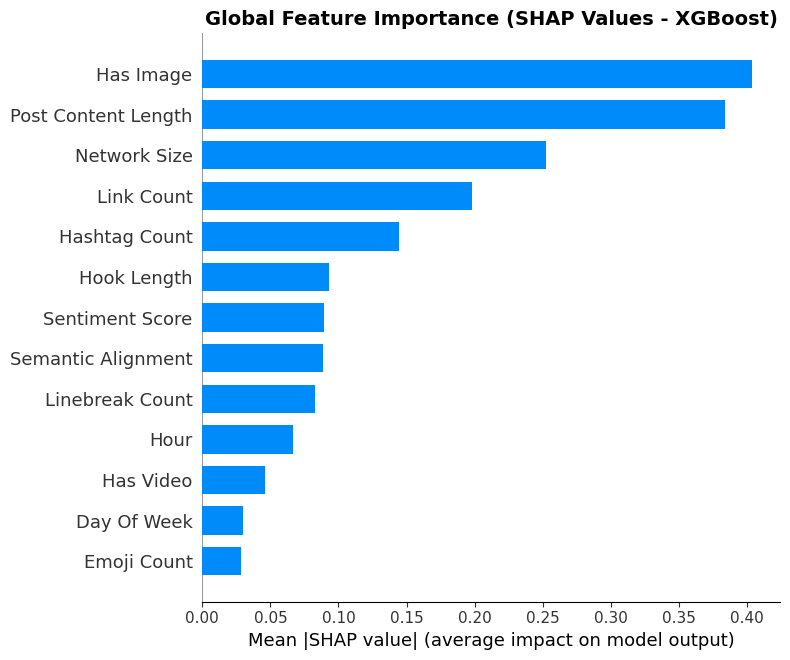


Plot 2: SHAP Beeswarm Plot


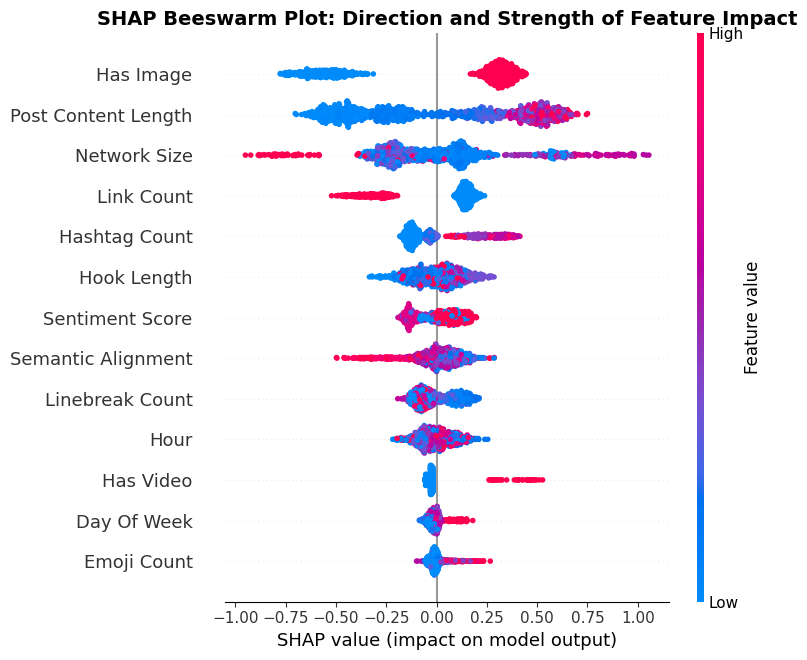


Plots 3-8: Individual Feature Dependence Plots (Separate Figures)


<Figure size 700x400 with 0 Axes>

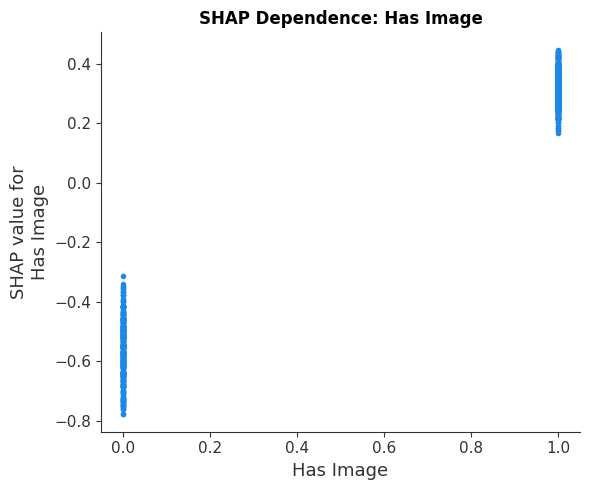

<Figure size 700x400 with 0 Axes>

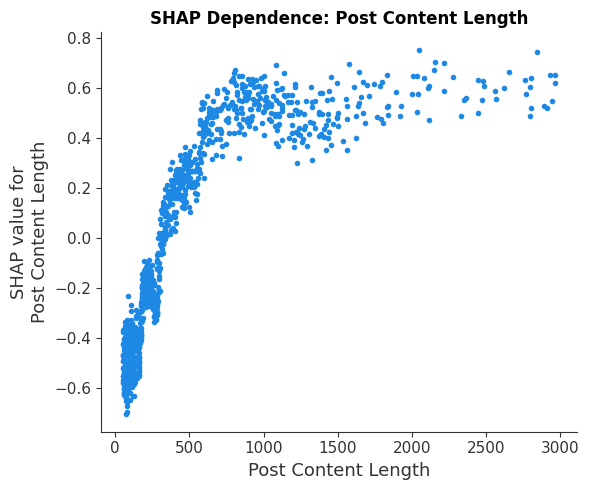

<Figure size 700x400 with 0 Axes>

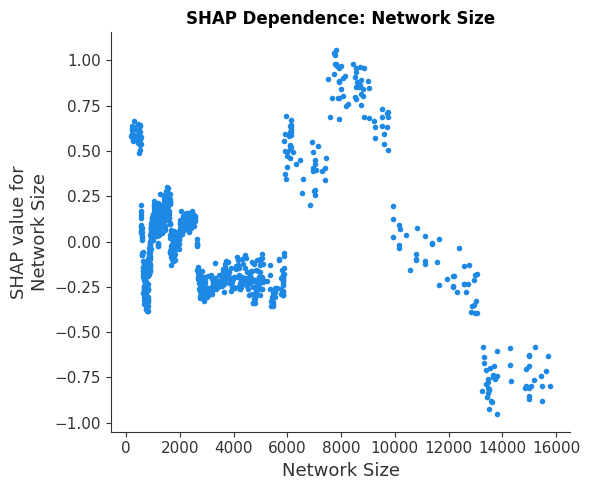

<Figure size 700x400 with 0 Axes>

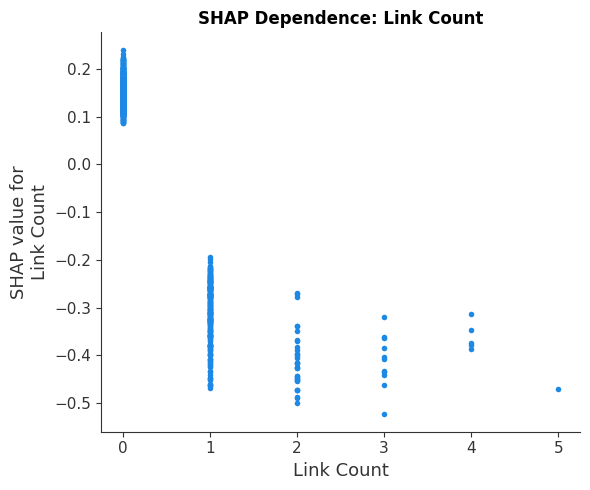

<Figure size 700x400 with 0 Axes>

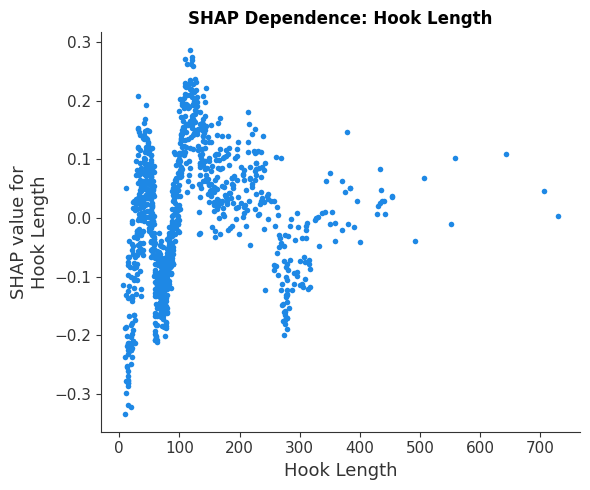

<Figure size 700x400 with 0 Axes>

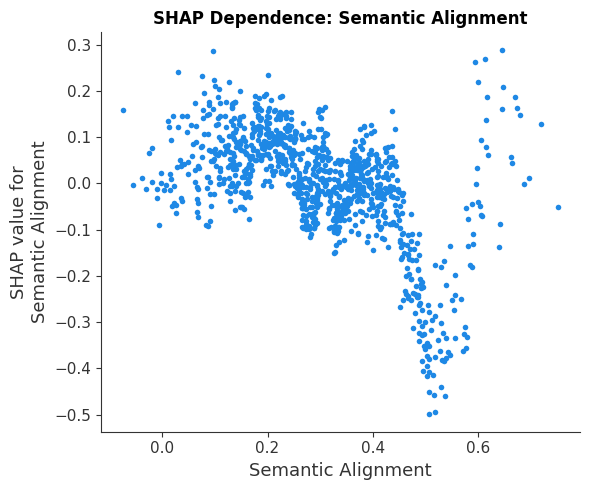


Plot 9: Temporal Features Analysis (Separate Figures)


<Figure size 700x400 with 0 Axes>

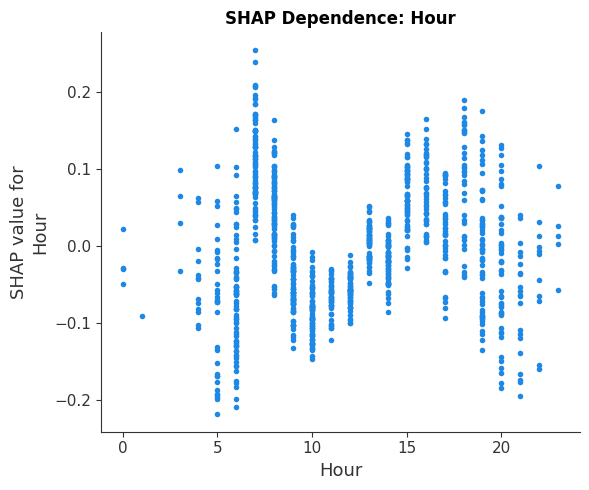

<Figure size 700x400 with 0 Axes>

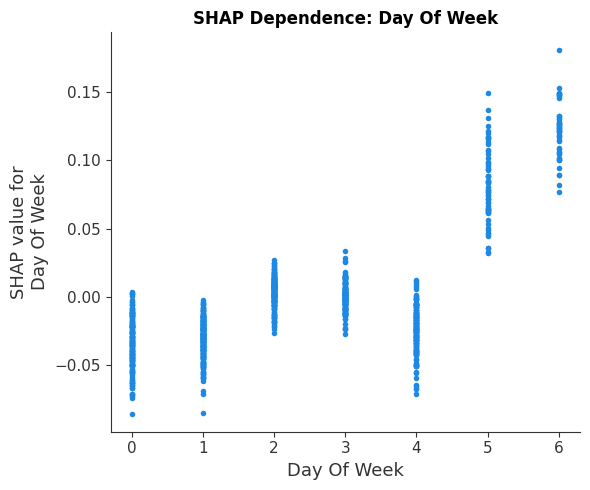


SHAP Analysis Summary

Feature Importance Ranking:
            Feature  Mean |SHAP|
          Has Image     0.404073
Post Content Length     0.384156
       Network Size     0.252626
         Link Count     0.197980
      Hashtag Count     0.144416
        Hook Length     0.093221
    Sentiment Score     0.089311
 Semantic Alignment     0.088466
    Linebreak Count     0.083034
               Hour     0.066801
          Has Video     0.045869
        Day Of Week     0.029818
        Emoji Count     0.028341

Top 5 Most Important Features:
  1. Has Image: 0.4041
  2. Post Content Length: 0.3842
  3. Network Size: 0.2526
  4. Link Count: 0.1980
  5. Hashtag Count: 0.1444

Timing Features Importance:
    Feature  Mean |SHAP|
       Hour     0.066801
Day Of Week     0.029818


In [12]:
# SHAP Analysis for XGBoost Model Explainability

print("\nGenerating SHAP analysis...")

# 1. Initialize the SHAP TreeExplainer
explainer = shap.TreeExplainer(best_model)

# 2. Compute SHAP values for test set
# For binary classification, this returns SHAP values for the positive class (class 1)
shap_values = explainer.shap_values(X_test)

# Handle different SHAP output formats (version compatibility)
# Older versions return array, newer return Explanation object
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Get values for class 1 (high-performing)
elif hasattr(shap_values, 'values'):
    shap_values = shap_values.values  # Extract numpy array from Explanation object

print(f"SHAP values shape: {shap_values.shape}")
print(f"Expected shape: ({len(X_test)}, {len(features)})")

# 3. Global Feature Importance (Bar Chart)
print("\nPlot 1: Global Feature Importance")
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values, 
    X_test, 
    feature_names=features,  # ← IMPORTANT: Pass feature names
    plot_type="bar", 
    show=False
)
plt.title("Global Feature Importance (SHAP Values - XGBoost)", fontsize=14, fontweight='bold')
plt.xlabel("Mean |SHAP value| (average impact on model output)")
plt.tight_layout()
plt.show()

# 4. Beeswarm Plot (Direction and Magnitude)
print("\nPlot 2: SHAP Beeswarm Plot")
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values, 
    X_test, 
    feature_names=features,  # ← IMPORTANT: Pass feature names
    show=False
)
plt.title("SHAP Beeswarm Plot: Direction and Strength of Feature Impact", 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 5. Individual Feature Dependence Plots (Separate Figures)
key_features_to_plot = [
    'Has Image',
    'Post Content Length', 
    'Network Size',
    'Link Count',
    'Hook Length',
    'Semantic Alignment'
]

print("\nPlots 3-8: Individual Feature Dependence Plots (Separate Figures)")
for feature in key_features_to_plot:
    if feature in features:
        plt.figure(figsize=(7, 4))
        shap.dependence_plot(
            feature,
            shap_values,
            X_test,
            feature_names=features,
            interaction_index=None, 
            show=False
        )
        plt.title(f'SHAP Dependence: {feature}', fontweight='bold')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Feature '{feature}' not found in features.")

# 6. Hour and Day of Week Analysis (Separate Figures)
print("\nPlot 9: Temporal Features Analysis (Separate Figures)")
for feature in ['Hour', 'Day Of Week']:
    if feature in features:
        plt.figure(figsize=(7, 4))
        shap.dependence_plot(
            feature,
            shap_values,
            X_test,
            feature_names=features,
            interaction_index=None, 
            show=False
        )
        plt.title(f'SHAP Dependence: {feature}', fontweight='bold')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Feature '{feature}' not found in features.")

# 7. Individual Feature Value Distributions (Separate Figures)
key_features_to_plot_dist = [
    'Has Image',
    'Post Content Length', 
    'Network Size',
    'Link Count',
    'Hook Length',
    'Semantic Alignment',
    'Hour',
    'Day Of Week'
]
# 8. Summary Statistics
print("\n" + "="*60)
print("SHAP Analysis Summary")
print("="*60)

# Calculate mean absolute SHAP values for ranking
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Mean |SHAP|': mean_abs_shap
}).sort_values('Mean |SHAP|', ascending=False)

print("\nFeature Importance Ranking:")
print(feature_importance_df.to_string(index=False))

# Identify top 5 features
top_5_features = feature_importance_df.head(5)['Feature'].tolist()
print(f"\nTop 5 Most Important Features:")
for i, feat in enumerate(top_5_features, 1):
    importance = feature_importance_df[feature_importance_df['Feature'] == feat]['Mean |SHAP|'].values[0]
    print(f"  {i}. {feat}: {importance:.4f}")

# Check if timing features are important
timing_features = ['Hour', 'Day Of Week']
timing_importance = feature_importance_df[feature_importance_df['Feature'].isin(timing_features)]
print(f"\nTiming Features Importance:")
print(timing_importance.to_string(index=False))

if timing_importance['Mean |SHAP|'].max() < 0.05:
    print("  → Timing features have minimal impact (< 0.05)")
    print("  → Content and structure dominate prediction")

print("="*60)
